# Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as bs
import klib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from datetime import datetime
import joblib

# Downloading, Saving and Reading the Dataset

In [2]:
# Downloading the Dataset

train_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None)
test_set = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test' , skiprows = 1, header = None)

if not os.path.isdir('Dataset'):
    os.mkdir('Dataset')
    
# Downloading and Printing the Description
    
description = uReq('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names')
print(bs(description.read(), 'html.parser'))
description.close()

| This data was extracted from the census bureau database found at
| http://www.census.gov/ftp/pub/DES/www/welcome.html
| Donor: Ronny Kohavi and Barry Becker,
|        Data Mining and Visualization
|        Silicon Graphics.
|        e-mail: ronnyk@sgi.com for questions.
| Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random).
| 48842 instances, mix of continuous and discrete    (train=32561, test=16281)
| 45222 if instances with unknown values are removed (train=30162, test=15060)
| Duplicate or conflicting instances : 6
| Class probabilities for adult.all file
| Probability for the label '&gt;50K'  : 23.93% / 24.78% (without unknowns)
| Probability for the label '&lt;=50K' : 76.07% / 75.22% (without unknowns)
|
| Extraction was done by Barry Becker from the 1994 Census database.  A set of
|   reasonably clean records was extracted using the following conditions:
|   ((AAGE&gt;16) &amp;&amp; (AGI&gt;100) &amp;&amp; (AFNLWGT&gt;1)&amp;&amp; (HRSWK&gt;0))
|
| Prediction task i

In [3]:
train_set

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [6]:
col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', \
'marital_status', 'occupation','relationship', 'race', 'sex', 'capital_gain', \
'capital_loss', 'hours_per_week', 'native_country', 'wage_class'] 


# Setting the column names for the training and the test data

train_set.columns = col_labels 
test_set.columns = col_labels


# Saving the data as a csv file

train_set.to_csv(os.path.join('Dataset', 'adult_data.csv'), index=False)
test_set.to_csv(os.path.join('Dataset', 'adult_test.csv'), index=False)

In [8]:
# Reading the dataset

data = pd.read_csv(os.path.join('Dataset', 'adult_data.csv'))
data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  wage_class      32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [10]:
data.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [11]:
data.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
wage_class        0
dtype: int64

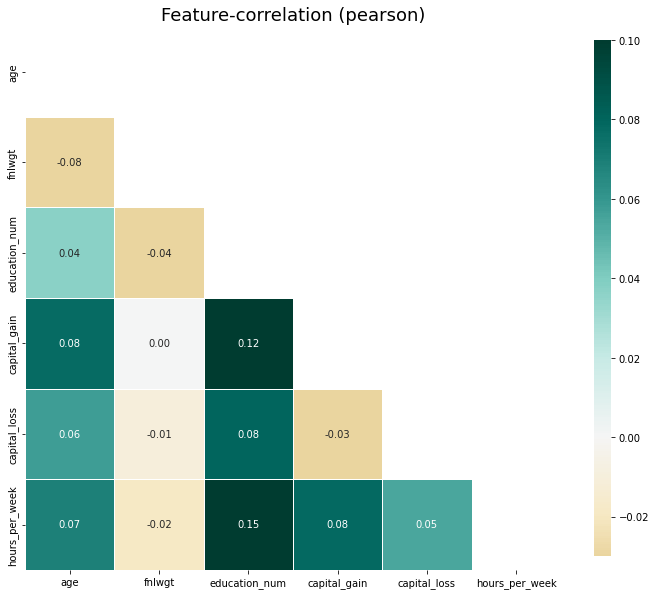

In [12]:
klib.corr_plot(data)
plt.show()

In [9]:
# Checking the number of target classes

data['wage_class'].value_counts()

 <=50K    24720
 >50K      7841
Name: wage_class, dtype: int64

In [13]:
# Prining the ratio of the classes

data['wage_class'].value_counts()[0] / data['wage_class'].value_counts()[1]

3.152659099604642

# Preprocessing the Data

In [16]:
# Balancing the Dataset

selected_dataframe = data[data['wage_class'] == ' >50K']
new_data = pd.concat([selected_dataframe] * 3, ignore_index=True)

new_data = new_data.append(data[data['wage_class'] == ' <=50K'], ignore_index=True)
new_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
1,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
2,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K
3,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,>50K
4,30,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,India,>50K


In [17]:
# Checking the number of target classes

new_data['wage_class'].value_counts()

 <=50K    24720
 >50K     23523
Name: wage_class, dtype: int64

In [18]:
# Prining the ratio of the classes

new_data['wage_class'].value_counts()[0] / new_data['wage_class'].value_counts()[1]

1.0508863665348807

In [29]:
new_data.dtypes[new_data.dtypes == 'int64'].index

Index(['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week'],
      dtype='object')

In [28]:
new_data.dtypes[new_data.dtypes == 'object'].index

Index(['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country', 'wage_class'],
      dtype='object')

In [30]:
# Dividing the numerical and categorical columns

numerical_columns = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
categorical_columns = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']

In [35]:
new_data['wage_class'].value_counts()

 <=50K    24720
 >50K     23523
Name: wage_class, dtype: int64

In [36]:
# removing heading and trailing blank space and dots

for i in categorical_columns:
    new_data[i] = new_data[i].map(lambda name: name.strip())
    
new_data['wage_class'] = new_data['wage_class'].map(lambda name: name.strip(' ').strip('.'))

In [37]:
# Changing some values

new_data['workclass'].replace(to_replace='?', value='Other', inplace=True)
new_data['occupation'].replace(to_replace='?', value='Other', inplace=True)

In [38]:
new_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
1,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
2,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K
3,37,Private,280464,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,>50K
4,30,State-gov,141297,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,India,>50K


In [39]:
# Divind the data into training data, test data and their targets respectively

X_train, X_test, y_train, y_test = train_test_split(new_data.drop(labels=['wage_class'], axis=1), new_data['wage_class'], test_size=0.20, random_state=33)

In [40]:
X_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
33032,45,Private,151627,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Female,0,0,45,United-States
23296,52,Private,174752,HS-grad,9,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States
29571,19,Private,281704,Some-college,10,Never-married,Other-service,Not-in-family,White,Male,0,0,35,United-States
7854,50,Federal-gov,251585,Bachelors,13,Divorced,Exec-managerial,Not-in-family,White,Male,0,0,55,United-States
37854,38,Private,52963,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,50,United-States


In [41]:
y_train.head()

33032    <=50K
23296     >50K
29571    <=50K
7854      >50K
37854    <=50K
Name: wage_class, dtype: object

In [42]:
# pipelines to handle numerical and categorical data for the training data

num_pipeline = Pipeline([
    ('num_std', StandardScaler())
])

full_pipeline = ColumnTransformer([
    ('num_pipeline', num_pipeline, numerical_columns),
    ('cat_data', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
])

# Pipeline to handle the target data

target_encoder = LabelEncoder()

In [43]:
prepared_data = full_pipeline.fit_transform(X_train)
prepared_data.toarray()[0:5]

array([[ 0.35374849, -0.36240877, -0.21876683, -0.1953465 , -0.25747698,
         0.23938335,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [44]:
prepared_target = target_encoder.fit_transform(y_train)
prepared_target[:5]

array([0, 1, 0, 1, 0])

# Creating the ML Model

In [45]:
# Defining the model object

xgb_clf = XGBClassifier(eval_metric='logloss', use_label_encoder=False, tree_method='gpu_hist', gpu_id=0)

### Checking Accuracy on Training Data

In [46]:
# Using Cross Validation to Check for the performance of the model on training data

cross_val_score(estimator=xgb_clf, X=prepared_data, y=prepared_target, cv=10, n_jobs=-1, verbose=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   11.3s remaining:   26.6s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   11.5s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.5s finished


array([0.86658031, 0.86891192, 0.86476684, 0.85518135, 0.87017362,
       0.86110391, 0.85462555, 0.86291785, 0.8662866 , 0.86265872])

### Checking Accuracy on Splitted-Test Data

In [53]:
# Preparing the Test Data

prepared_test_data = full_pipeline.transform(X_test)
prepared_test_target = target_encoder.transform(y_test)

In [54]:
cross_val_score(estimator=xgb_clf, X=prepared_test_data, y=prepared_test_target, n_jobs=-1, verbose=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.0s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


array([0.83937824, 0.85958549, 0.85595855, 0.82953368, 0.85225505])

# Training the Model

In [55]:
xgb_clf.fit(prepared_data, prepared_target)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [56]:
y_pred = xgb_clf.predict(prepared_test_data)
y_pred

array([1, 1, 0, ..., 1, 1, 1])

# Checking for Metrics

In [30]:
# Printing the classification report

print(classification_report(y_true=prepared_test_target, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      4890
           1       0.85      0.90      0.87      4759

    accuracy                           0.87      9649
   macro avg       0.87      0.87      0.87      9649
weighted avg       0.87      0.87      0.87      9649



In [31]:
# Printing the confusion Matrix

print(confusion_matrix(y_true=prepared_test_target, y_pred=y_pred))

[[4124  766]
 [ 476 4283]]


In [32]:
target_encoder.inverse_transform(y_pred)

array(['>50K', '>50K', '<=50K', ..., '>50K', '>50K', '>50K'], dtype=object)

# Hyper Parameter Tuning

In [33]:
# Defining the list of Parameters

param_grid = dict(n_jobs=[-1],
                  eval_metric= ['logloss'],
                  n_estimators = range(1,10),
                  learning_rate = [0.001, 0.01, 0.1, 1],
                  verbosity = [3],
                  booster = ['gbtree', 'gblinear'],
                  gpu_id = [0],
                  tree_method= ['gpu_hist'],
                  num_parallel_tree = range(1, 10),
                  gamma = np.arange(0,10,0.1),
                  min_child_weight = np.arange(1,10), 
                  use_label_encoder=[False])


In [ ]:
# set1 = -1, logloss, 1, 0.01, 3, gbtree, 0, gpu_hist, 1, 0, 1, False
# set2 = -1, logloss, 2, 0.01, 3, gbtree, 0, gpu_hist, 1, 0, 1, False
# set3 = -1, logloss, 1, 0.1, 3, gbtree, 0, gpu_hist, 1, 0, 1, False
# set4 = -1, logloss, 2, 0.1, 3, gbtree, 0, gpu_hist, 1, 0, 1, False
# .
# .
# .
# set1600 = 

# xgb(set1) -> 
# xgb(set2) -> 
# .
# .
# .
# xgb(set1600) ->

In [34]:
# Defining the gridsearch object and finding the best model

grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=3)

grid_search.fit(prepared_data, prepared_target)

Fitting 10 folds for each of 1600 candidates, totalling 16000 fits
[20:22:16] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_gpu_hist.cu:873: [GPU Hist]: Configure
[20:22:16] ======== Monitor (0): SketchContainer ========
[20:22:16] MakeCuts: 0.000696s, 1 calls @ 696us

[20:22:16] Prune: 0.000411s, 1 calls @ 411us

[20:22:16] ScanInput: 0.000905s, 1 calls @ 905us

[20:22:16] Unique: 0.00025s, 1 calls @ 250us

[20:22:16] ======== Monitor (0): Learner ========
[20:22:16] Configure: 0s, 1 calls @ 0us

[20:22:16] EvalOneIter: 1.8e-05s, 2 calls @ 18us

[20:22:16] GetGradient: 0.000565s, 2 calls @ 565us

[20:22:16] PredictRaw: 0.000627s, 2 calls @ 627us

[20:22:16] UpdateOneIter: 0.040844s, 2 calls @ 40844us

[20:22:16] ======== Monitor (0): GBTree ========
[20:22:16] BoostNewTrees: 0.102203s, 2 calls @ 102203us

[20:22:16] CommitModel: 1e-06s, 2 calls @ 1us

[20:22:16] ======== Device 0 Memory Allocations:  ========
[20:22:16] Peak memory usage: 8MiB
[2

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=0, gpu_id=0,
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraint...
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]),
                         'gpu_id': [0]

In [35]:
# The computed best model

grid_search.best_estimator_

[20:22:17] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_gpu_hist.cu:873: [GPU Hist]: Configure
[20:22:17] ======== Device 0 Memory Allocations:  ========
[20:22:17] Peak memory usage: 8MiB
[20:22:17] Number of allocations: 288
[20:22:17] ======== Monitor (0):  ========


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=3.2, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=2, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='gpu_hist', use_label_encoder=False,
              validate_parameters=1, verbosity=3)

In [36]:
# The best set of parameters

grid_search.best_params_

{'booster': 'gbtree',
 'eval_metric': 'logloss',
 'gamma': 3.2,
 'gpu_id': 0,
 'learning_rate': 0.1,
 'min_child_weight': 1,
 'n_estimators': 2,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'tree_method': 'gpu_hist',
 'use_label_encoder': False,
 'verbosity': 3}

In [37]:
# The best scores

grid_search.best_score_

0.8220708873812244

# Checking for Metrics

In [38]:
best_model = grid_search.best_estimator_
best_model.fit(prepared_data, prepared_target)
y_pred = best_model.predict(prepared_test_data)

[20:22:17] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_gpu_hist.cu:873: [GPU Hist]: Configure
[20:22:17] ======== Monitor (0): SketchContainer ========
[20:22:17] MakeCuts: 0.003552s, 1 calls @ 3552us

[20:22:17] Prune: 0.003237s, 1 calls @ 3237us

[20:22:17] ScanInput: 0.0009s, 1 calls @ 900us

[20:22:17] Unique: 0.000249s, 1 calls @ 249us

[20:22:17] ======== Monitor (0): Learner ========
[20:22:17] Configure: 0.000499s, 1 calls @ 499us

[20:22:17] EvalOneIter: 1.7e-05s, 2 calls @ 17us

[20:22:17] GetGradient: 0.000627s, 2 calls @ 627us

[20:22:17] PredictRaw: 0.000567s, 2 calls @ 567us

[20:22:17] UpdateOneIter: 0.184737s, 2 calls @ 184737us

[20:22:17] ======== Monitor (0): GBTree ========
[20:22:17] BoostNewTrees: 0.182991s, 2 calls @ 182991us

[20:22:17] CommitModel: 1e-06s, 2 calls @ 1us

[20:22:17] ======== Device 0 Memory Allocations:  ========
[20:22:17] Peak memory usage: 8MiB
[20:22:17] Number of allocations: 576
[20:22:17] ======== 

In [39]:
# Printing the classification report

print(classification_report(y_true=prepared_test_target, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81      4890
           1       0.78      0.89      0.83      4759

    accuracy                           0.82      9649
   macro avg       0.83      0.82      0.82      9649
weighted avg       0.83      0.82      0.82      9649



In [40]:
# Printing the confusion Matrix

print(confusion_matrix(y_true=prepared_test_target, y_pred=y_pred))

[[3717 1173]
 [ 542 4217]]


# Saving the Models

In [59]:
# This function is used to generate the file name

def gen_filename(file_name):
    now=datetime.now()
    date_time = now.strftime("%d-%m-%Y_%H-%M-%S")
    return date_time + '_' + file_name

In [42]:
# Saving the Pipelines

joblib.dump(value=full_pipeline, filename=os.path.join('Pipelines', gen_filename('full_pipeline.pkl')))
joblib.dump(value=target_encoder, filename=os.path.join('Pipelines', gen_filename('target_encoder.pkl')))


# Saving the Model

joblib.dump(value=grid_search.best_estimator_, filename=os.path.join('Model', gen_filename('xgb_clf.pkl')))

print('Pipelines and Model Saved')

Pipelines and Model Saved


# Prediction on the provided test data

In [65]:
# loading the test data file

train = pd.read_csv(os.path.join('Dataset', 'adult_test.csv')).drop('wage_class', axis = 1)

test = pd.read_csv(os.path.join('Dataset', 'adult_test.csv'))[['wage_class']]

In [66]:
train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States


In [67]:
test.head()

,wage_class
0,<=50K.
1,<=50K.
2,>50K.
3,>50K.
4,<=50K.


In [68]:
# preprocessing the data

for i in categorical_columns:
    train[i] = train[i].map(lambda name: name.strip())
    
test['wage_class'] = test['wage_class'].map(lambda name: name.strip(' ').strip('.'))

In [69]:
# loading the transformers

full_transformer = joblib.load(os.path.join('Pipelines', '02-10-2022_19-41-10_full_pipeline.pkl'))
target_transformer = joblib.load(os.path.join('Pipelines', '02-10-2022_19-41-10_target_encoder.pkl'))

In [70]:
# preparing the test data

prepared_data = full_transformer.transform(train)
prepared_data.toarray()

array([[-1.18287239,  0.35303692, -1.36634115, ...,  1.        ,
         0.        ,  0.        ],
       [-0.18406882, -0.95068738, -0.6012916 , ...,  1.        ,
         0.        ,  0.        ],
       [-0.95237926,  1.40133259,  0.54628273, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.18406882,  1.76328577,  0.9288075 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.27691745, -1.00705698,  0.9288075 , ...,  1.        ,
         0.        ,  0.        ],
       [-0.41456195, -0.0719383 ,  0.9288075 , ...,  1.        ,
         0.        ,  0.        ]])

In [71]:
# preparing the test target

prepared_target = target_transformer.transform(test['wage_class'])

In [72]:
prepared_target

array([0, 0, 1, ..., 0, 0, 1])

In [73]:
# loading the best model

best_model = joblib.load(os.path.join('Model', '02-10-2022_19-41-10_xgb_clf.pkl'))

In [74]:
# finding the predictions

y_pred = best_model.predict(prepared_data)
y_pred

array([0, 1, 1, ..., 1, 0, 1])

In [75]:
# Printing the classification report

print(classification_report(y_true=prepared_target, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85     12435
           1       0.54      0.87      0.66      3846

    accuracy                           0.79     16281
   macro avg       0.74      0.82      0.76     16281
weighted avg       0.85      0.79      0.81     16281



In [76]:
# Printing the confusion matrix

print(confusion_matrix(y_true=prepared_target, y_pred=y_pred))

[[9531 2904]
 [ 488 3358]]


### Actual Value

In [77]:
# Finding the actual predicted value

target_transformer.inverse_transform(y_pred)

array(['<=50K', '>50K', '>50K', ..., '>50K', '<=50K', '>50K'],
      dtype=object)

In [56]:
# Assigning the actual value to a dataframe

train['Actual income'] = test

In [57]:
# Assigning the predicted value to a dataframe

train['Predicted_income'] = target_transformer.inverse_transform(y_pred)

In [58]:
train

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,Actual income,Predicted_income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K,>50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K,<=50K
16277,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K,<=50K
16278,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K,>50K
16279,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K,<=50K
